Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import scipy.io
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs

# Sample from latent Lorenz attractor:


In [2]:
Time = 15  # 50 worse
neuron_num = 30
all_time =1500
datax = scipy.io.loadmat("spike30_sim_1500.mat")
y_data = datax["spike30_sim_1500"] 
traj = scipy.io.loadmat("trj30_sim_1500.mat")
traj = traj["trj30_sim_1500"]
print(traj.shape)

(1500, 2)


(15, 30)


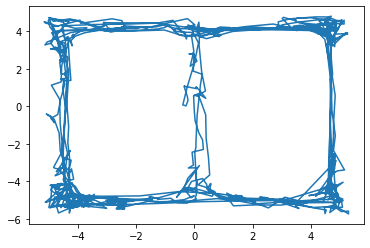

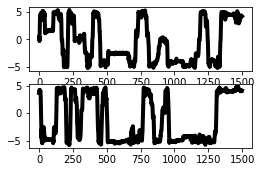

In [3]:
factor_dim = 10

NRep=int(all_time/Time)
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    output[i,:,:] = y_data[Time*i:Time*(i+1),:]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)

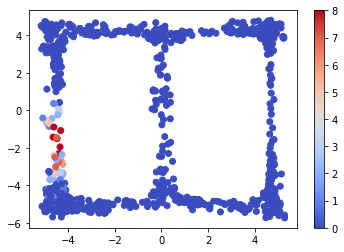

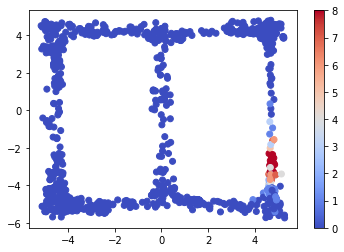

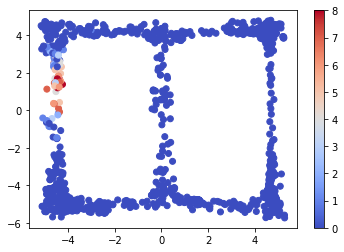

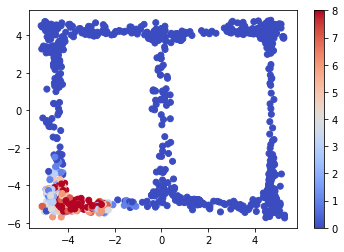

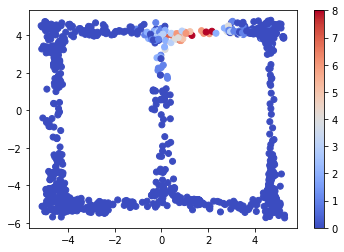

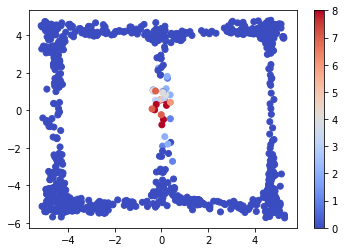

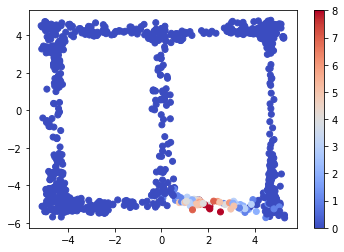

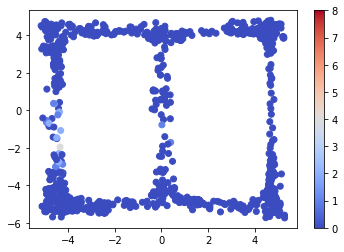

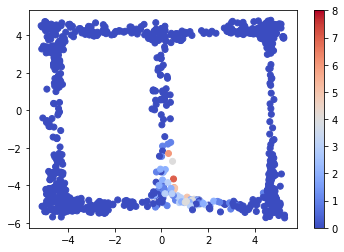

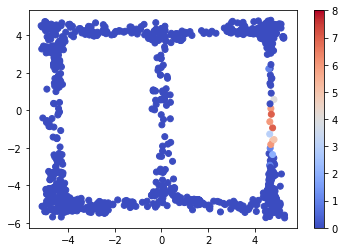

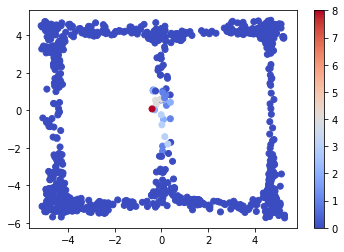

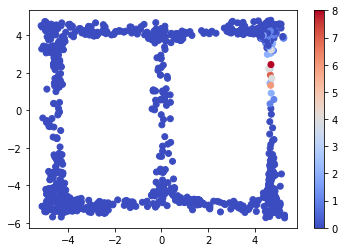

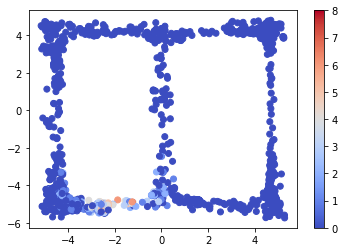

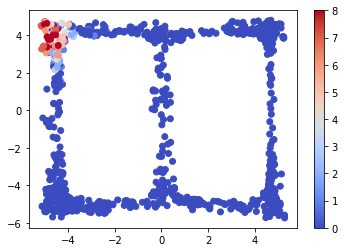

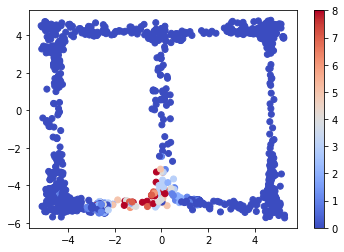

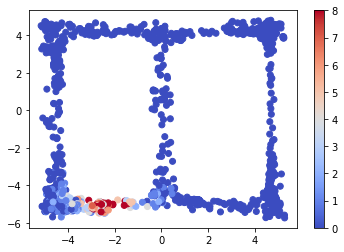

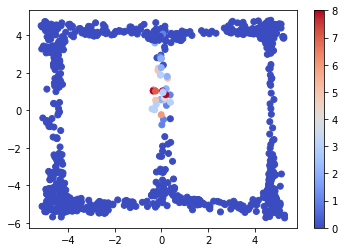

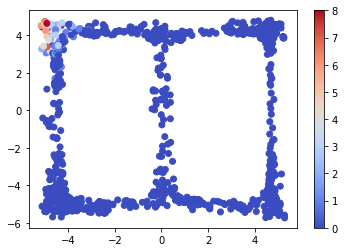

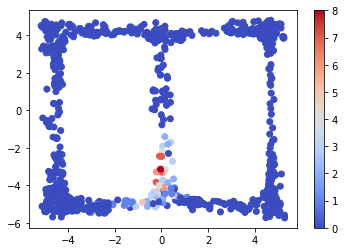

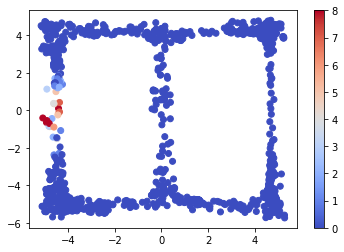

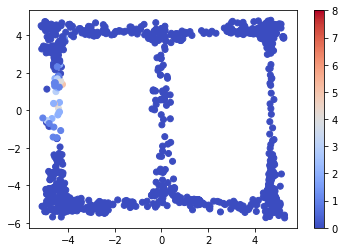

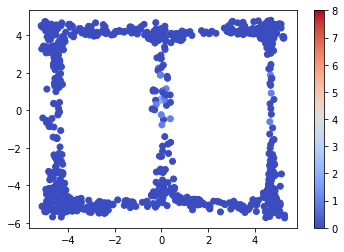

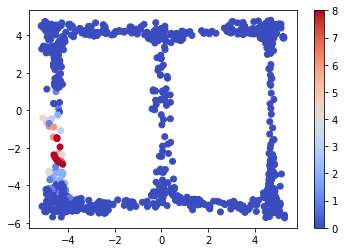

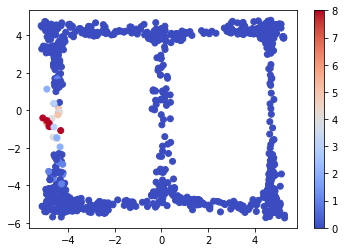

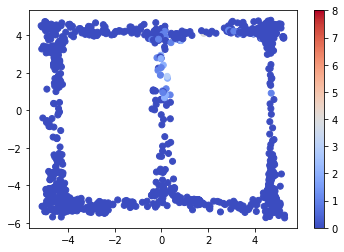

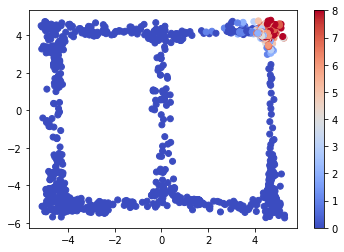

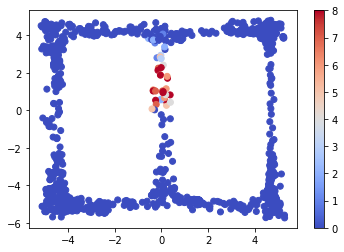

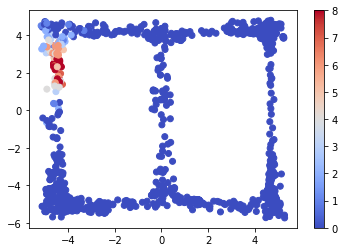

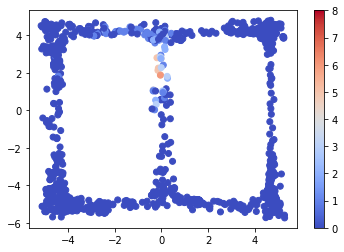

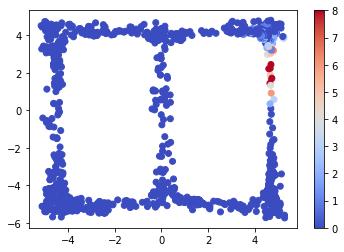

In [22]:
for i in range(neuron_num):
    fig, ax = plt.subplots()
    mappable = ax.scatter(traj[:,0], traj[:,1], c=y_data[:,i] ,cmap='coolwarm',vmin=0,vmax=8)
    fig.colorbar(mappable)
    plt.show()

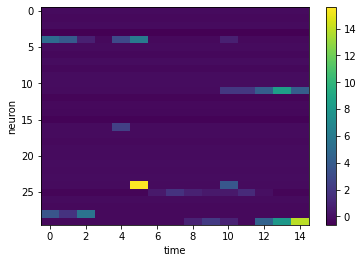

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('time')
plt.ylabel('neuron')
plt.colorbar()
plt.show()

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((output))
#print(dataset)
#dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=factor_dim,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        self.dense_output = tf.keras.layers.Dense(256, activation='relu')
        self.dense_output2 = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        x2 = self.dense_output(x)
        xo = self.dense_output2(x2)
        #xo = tf.exp(x2)
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=factor_dim,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [17]:
BATCH_SIZE = 5 # 1 good , 5 not so good
batched_dataset = dataset.batch(BATCH_SIZE)
batched_dataset_test = dataset.batch(1)

In [12]:
vae = VariationalAutoEncoder(latent_dim=64,
                             num_gru_unit=32,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=factor_dim)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=8e-4,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,10)

In [15]:
epochs = 1500

for i,kl_ in enumerate(KL_penalty):
    print(kl_,i)
    if i > 0:
        break
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,),'i',i)

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                #print("loss",loss,"kl",sum(vae.losses))
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

0.0 0
Start of epoch 0 i 0
step 0: mean loss = 1.0004662
Start of epoch 1 i 0
step 0: mean loss = 1.0031312
Start of epoch 2 i 0
step 0: mean loss = 1.0001845
Start of epoch 3 i 0
step 0: mean loss = 0.99802935
Start of epoch 4 i 0
step 0: mean loss = 0.9944346
Start of epoch 5 i 0
step 0: mean loss = 0.9874428
Start of epoch 6 i 0
step 0: mean loss = 0.97828907
Start of epoch 7 i 0
step 0: mean loss = 0.96669656
Start of epoch 8 i 0
step 0: mean loss = 0.9552599
Start of epoch 9 i 0
step 0: mean loss = 0.9424624
Start of epoch 10 i 0
step 0: mean loss = 0.92894006
Start of epoch 11 i 0
step 0: mean loss = 0.91584253
Start of epoch 12 i 0
step 0: mean loss = 0.901865
Start of epoch 13 i 0
step 0: mean loss = 0.8883583
Start of epoch 14 i 0
step 0: mean loss = 0.8752712
Start of epoch 15 i 0
step 0: mean loss = 0.86305344
Start of epoch 16 i 0
step 0: mean loss = 0.85232383
Start of epoch 17 i 0
step 0: mean loss = 0.84159344
Start of epoch 18 i 0
step 0: mean loss = 0.8317251
Start of 

Start of epoch 156 i 0
step 0: mean loss = 0.462735
Start of epoch 157 i 0
step 0: mean loss = 0.4617794
Start of epoch 158 i 0
step 0: mean loss = 0.4607697
Start of epoch 159 i 0
step 0: mean loss = 0.4597802
Start of epoch 160 i 0
step 0: mean loss = 0.4588509
Start of epoch 161 i 0
step 0: mean loss = 0.45798957
Start of epoch 162 i 0
step 0: mean loss = 0.45716414
Start of epoch 163 i 0
step 0: mean loss = 0.45632163
Start of epoch 164 i 0
step 0: mean loss = 0.45548803
Start of epoch 165 i 0
step 0: mean loss = 0.45463493
Start of epoch 166 i 0
step 0: mean loss = 0.4536942
Start of epoch 167 i 0
step 0: mean loss = 0.4528296
Start of epoch 168 i 0
step 0: mean loss = 0.452026
Start of epoch 169 i 0
step 0: mean loss = 0.45117295
Start of epoch 170 i 0
step 0: mean loss = 0.45032778
Start of epoch 171 i 0
step 0: mean loss = 0.44945
Start of epoch 172 i 0
step 0: mean loss = 0.44856232
Start of epoch 173 i 0
step 0: mean loss = 0.4476558
Start of epoch 174 i 0
step 0: mean loss =

Start of epoch 309 i 0
step 0: mean loss = 0.36638477
Start of epoch 310 i 0
step 0: mean loss = 0.36593887
Start of epoch 311 i 0
step 0: mean loss = 0.3655261
Start of epoch 312 i 0
step 0: mean loss = 0.36512724
Start of epoch 313 i 0
step 0: mean loss = 0.36475086
Start of epoch 314 i 0
step 0: mean loss = 0.36433303
Start of epoch 315 i 0
step 0: mean loss = 0.3639058
Start of epoch 316 i 0
step 0: mean loss = 0.36346266
Start of epoch 317 i 0
step 0: mean loss = 0.3630416
Start of epoch 318 i 0
step 0: mean loss = 0.36263028
Start of epoch 319 i 0
step 0: mean loss = 0.36224595
Start of epoch 320 i 0
step 0: mean loss = 0.36187512
Start of epoch 321 i 0
step 0: mean loss = 0.36150342
Start of epoch 322 i 0
step 0: mean loss = 0.3610911
Start of epoch 323 i 0
step 0: mean loss = 0.36065933
Start of epoch 324 i 0
step 0: mean loss = 0.36022457
Start of epoch 325 i 0
step 0: mean loss = 0.35980332
Start of epoch 326 i 0
step 0: mean loss = 0.35938358
Start of epoch 327 i 0
step 0: m

Start of epoch 462 i 0
step 0: mean loss = 0.31416497
Start of epoch 463 i 0
step 0: mean loss = 0.31390953
Start of epoch 464 i 0
step 0: mean loss = 0.3136352
Start of epoch 465 i 0
step 0: mean loss = 0.31335136
Start of epoch 466 i 0
step 0: mean loss = 0.31306627
Start of epoch 467 i 0
step 0: mean loss = 0.31278953
Start of epoch 468 i 0
step 0: mean loss = 0.3125256
Start of epoch 469 i 0
step 0: mean loss = 0.3122799
Start of epoch 470 i 0
step 0: mean loss = 0.31201038
Start of epoch 471 i 0
step 0: mean loss = 0.3117584
Start of epoch 472 i 0
step 0: mean loss = 0.311507
Start of epoch 473 i 0
step 0: mean loss = 0.31124568
Start of epoch 474 i 0
step 0: mean loss = 0.31096587
Start of epoch 475 i 0
step 0: mean loss = 0.3106799
Start of epoch 476 i 0
step 0: mean loss = 0.31041574
Start of epoch 477 i 0
step 0: mean loss = 0.3101805
Start of epoch 478 i 0
step 0: mean loss = 0.30994242
Start of epoch 479 i 0
step 0: mean loss = 0.30974635
Start of epoch 480 i 0
step 0: mean 

Start of epoch 615 i 0
step 0: mean loss = 0.2791841
Start of epoch 616 i 0
step 0: mean loss = 0.27907807
Start of epoch 617 i 0
step 0: mean loss = 0.27894703
Start of epoch 618 i 0
step 0: mean loss = 0.27881202
Start of epoch 619 i 0
step 0: mean loss = 0.2786467
Start of epoch 620 i 0
step 0: mean loss = 0.27846783
Start of epoch 621 i 0
step 0: mean loss = 0.2782749
Start of epoch 622 i 0
step 0: mean loss = 0.2780722
Start of epoch 623 i 0
step 0: mean loss = 0.2778597
Start of epoch 624 i 0
step 0: mean loss = 0.2776432
Start of epoch 625 i 0
step 0: mean loss = 0.27742425
Start of epoch 626 i 0
step 0: mean loss = 0.2772092
Start of epoch 627 i 0
step 0: mean loss = 0.2769883
Start of epoch 628 i 0
step 0: mean loss = 0.27676588
Start of epoch 629 i 0
step 0: mean loss = 0.2765449
Start of epoch 630 i 0
step 0: mean loss = 0.27632865
Start of epoch 631 i 0
step 0: mean loss = 0.2761093
Start of epoch 632 i 0
step 0: mean loss = 0.27589023
Start of epoch 633 i 0
step 0: mean lo

Start of epoch 768 i 0
step 0: mean loss = 0.25208947
Start of epoch 769 i 0
step 0: mean loss = 0.25192666
Start of epoch 770 i 0
step 0: mean loss = 0.2517638
Start of epoch 771 i 0
step 0: mean loss = 0.2515984
Start of epoch 772 i 0
step 0: mean loss = 0.2514346
Start of epoch 773 i 0
step 0: mean loss = 0.25127488
Start of epoch 774 i 0
step 0: mean loss = 0.25110963
Start of epoch 775 i 0
step 0: mean loss = 0.25094205
Start of epoch 776 i 0
step 0: mean loss = 0.25077435
Start of epoch 777 i 0
step 0: mean loss = 0.2506135
Start of epoch 778 i 0
step 0: mean loss = 0.25045872
Start of epoch 779 i 0
step 0: mean loss = 0.25030866
Start of epoch 780 i 0
step 0: mean loss = 0.25016186
Start of epoch 781 i 0
step 0: mean loss = 0.25001073
Start of epoch 782 i 0
step 0: mean loss = 0.24986011
Start of epoch 783 i 0
step 0: mean loss = 0.24969865
Start of epoch 784 i 0
step 0: mean loss = 0.24953164
Start of epoch 785 i 0
step 0: mean loss = 0.24936613
Start of epoch 786 i 0
step 0: m

Start of epoch 921 i 0
step 0: mean loss = 0.23088722
Start of epoch 922 i 0
step 0: mean loss = 0.23075667
Start of epoch 923 i 0
step 0: mean loss = 0.23061903
Start of epoch 924 i 0
step 0: mean loss = 0.23047876
Start of epoch 925 i 0
step 0: mean loss = 0.23033538
Start of epoch 926 i 0
step 0: mean loss = 0.23019286
Start of epoch 927 i 0
step 0: mean loss = 0.23005116
Start of epoch 928 i 0
step 0: mean loss = 0.22991183
Start of epoch 929 i 0
step 0: mean loss = 0.22977607
Start of epoch 930 i 0
step 0: mean loss = 0.22963798
Start of epoch 931 i 0
step 0: mean loss = 0.22950234
Start of epoch 932 i 0
step 0: mean loss = 0.22936946
Start of epoch 933 i 0
step 0: mean loss = 0.2292408
Start of epoch 934 i 0
step 0: mean loss = 0.22911152
Start of epoch 935 i 0
step 0: mean loss = 0.22898176
Start of epoch 936 i 0
step 0: mean loss = 0.22885217
Start of epoch 937 i 0
step 0: mean loss = 0.2287217
Start of epoch 938 i 0
step 0: mean loss = 0.2285889
Start of epoch 939 i 0
step 0: 

Start of epoch 1072 i 0
step 0: mean loss = 0.2131773
Start of epoch 1073 i 0
step 0: mean loss = 0.21306704
Start of epoch 1074 i 0
step 0: mean loss = 0.21296352
Start of epoch 1075 i 0
step 0: mean loss = 0.2128562
Start of epoch 1076 i 0
step 0: mean loss = 0.21274792
Start of epoch 1077 i 0
step 0: mean loss = 0.21263978
Start of epoch 1078 i 0
step 0: mean loss = 0.2125293
Start of epoch 1079 i 0
step 0: mean loss = 0.21241775
Start of epoch 1080 i 0
step 0: mean loss = 0.2123061
Start of epoch 1081 i 0
step 0: mean loss = 0.21219502
Start of epoch 1082 i 0
step 0: mean loss = 0.21208309
Start of epoch 1083 i 0
step 0: mean loss = 0.21197197
Start of epoch 1084 i 0
step 0: mean loss = 0.21186472
Start of epoch 1085 i 0
step 0: mean loss = 0.21175484
Start of epoch 1086 i 0
step 0: mean loss = 0.21165791
Start of epoch 1087 i 0
step 0: mean loss = 0.21156992
Start of epoch 1088 i 0
step 0: mean loss = 0.21150683
Start of epoch 1089 i 0
step 0: mean loss = 0.21144031
Start of epoch

Start of epoch 1222 i 0
step 0: mean loss = 0.19848667
Start of epoch 1223 i 0
step 0: mean loss = 0.1984008
Start of epoch 1224 i 0
step 0: mean loss = 0.19834912
Start of epoch 1225 i 0
step 0: mean loss = 0.19830467
Start of epoch 1226 i 0
step 0: mean loss = 0.19824
Start of epoch 1227 i 0
step 0: mean loss = 0.19816801
Start of epoch 1228 i 0
step 0: mean loss = 0.19809787
Start of epoch 1229 i 0
step 0: mean loss = 0.1980214
Start of epoch 1230 i 0
step 0: mean loss = 0.19793463
Start of epoch 1231 i 0
step 0: mean loss = 0.19784579
Start of epoch 1232 i 0
step 0: mean loss = 0.19776118
Start of epoch 1233 i 0
step 0: mean loss = 0.19767031
Start of epoch 1234 i 0
step 0: mean loss = 0.19758058
Start of epoch 1235 i 0
step 0: mean loss = 0.19750193
Start of epoch 1236 i 0
step 0: mean loss = 0.19742315
Start of epoch 1237 i 0
step 0: mean loss = 0.19733399
Start of epoch 1238 i 0
step 0: mean loss = 0.19724151
Start of epoch 1239 i 0
step 0: mean loss = 0.19715074
Start of epoch 

Start of epoch 1372 i 0
step 0: mean loss = 0.18574259
Start of epoch 1373 i 0
step 0: mean loss = 0.18568605
Start of epoch 1374 i 0
step 0: mean loss = 0.18564735
Start of epoch 1375 i 0
step 0: mean loss = 0.18559758
Start of epoch 1376 i 0
step 0: mean loss = 0.18553989
Start of epoch 1377 i 0
step 0: mean loss = 0.18547869
Start of epoch 1378 i 0
step 0: mean loss = 0.18541777
Start of epoch 1379 i 0
step 0: mean loss = 0.18535747
Start of epoch 1380 i 0
step 0: mean loss = 0.18529503
Start of epoch 1381 i 0
step 0: mean loss = 0.185237
Start of epoch 1382 i 0
step 0: mean loss = 0.18517296
Start of epoch 1383 i 0
step 0: mean loss = 0.18510729
Start of epoch 1384 i 0
step 0: mean loss = 0.18504605
Start of epoch 1385 i 0
step 0: mean loss = 0.1849793
Start of epoch 1386 i 0
step 0: mean loss = 0.18490547
Start of epoch 1387 i 0
step 0: mean loss = 0.18482824
Start of epoch 1388 i 0
step 0: mean loss = 0.18474728
Start of epoch 1389 i 0
step 0: mean loss = 0.18466409
Start of epoc

C:\Users\kdais\Anaconda3\envs\py36tg20\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\kdais\Anaconda3\envs\py36tg20\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\kdais\Anaconda3\envs\py36tg20\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this 

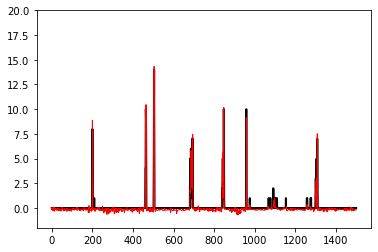

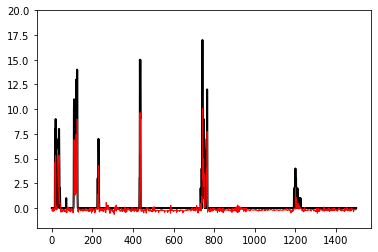

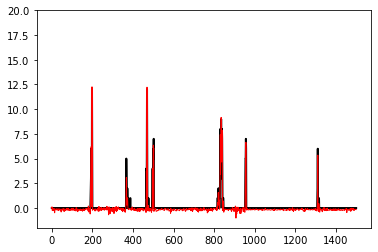

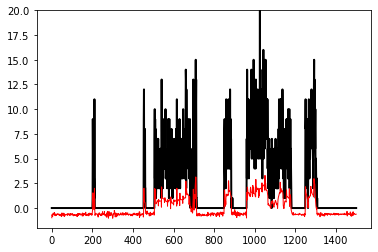

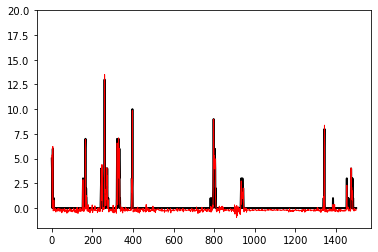

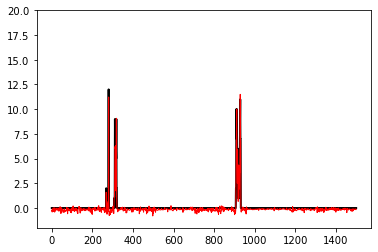

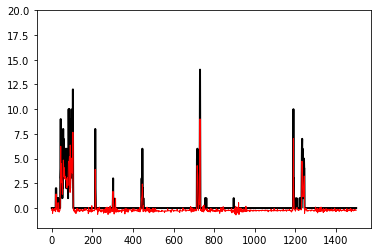

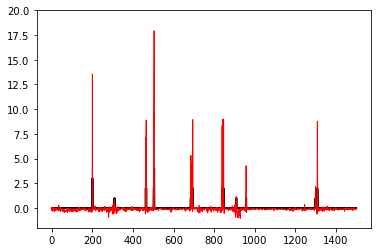

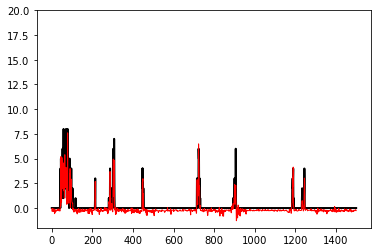

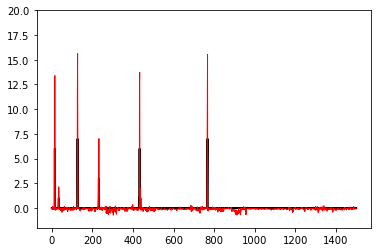

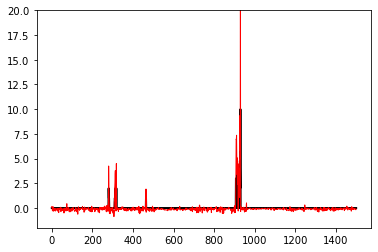

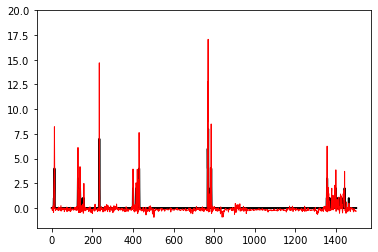

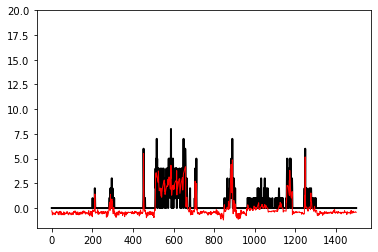

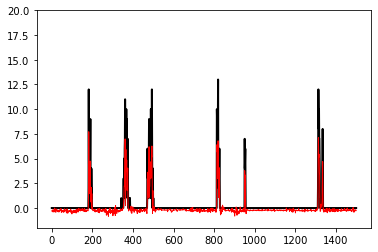

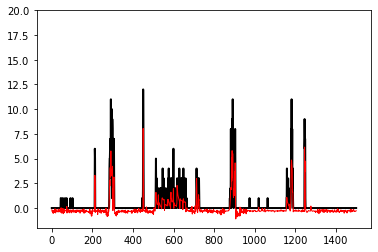

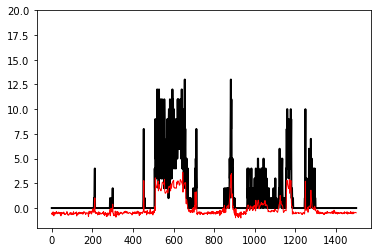

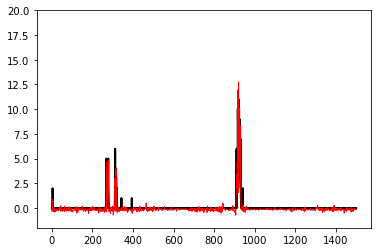

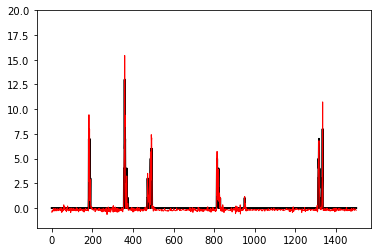

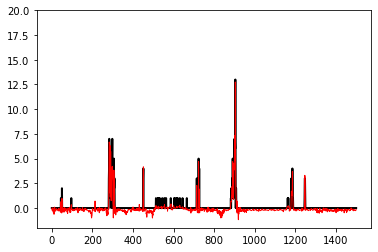

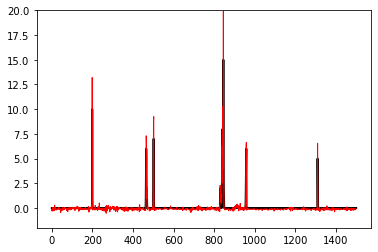

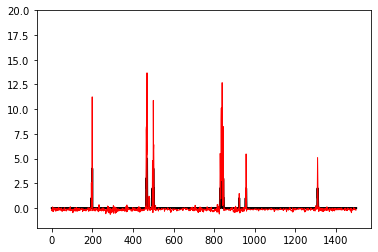

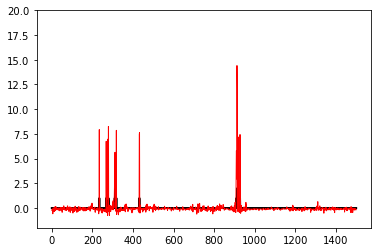

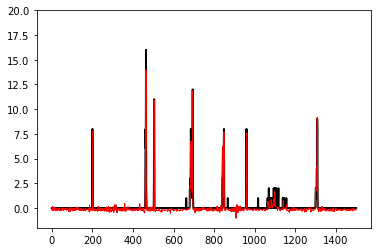

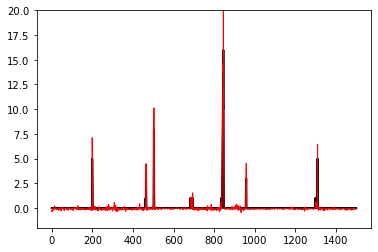

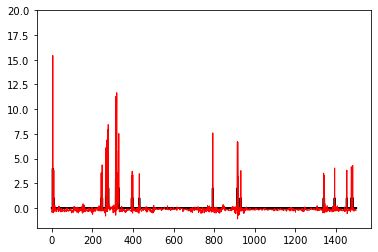

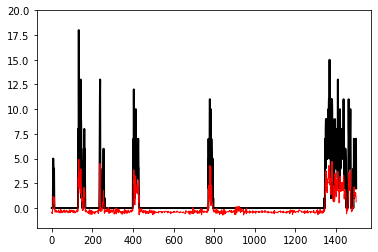

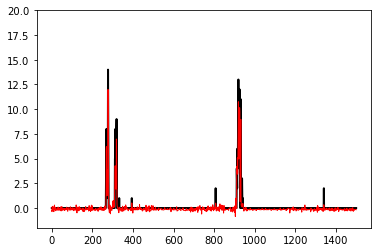

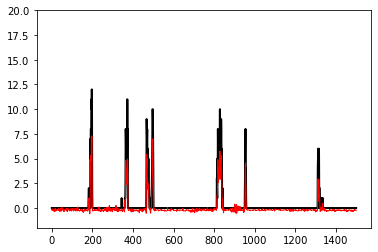

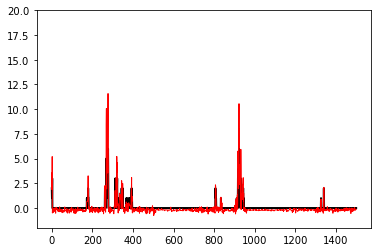

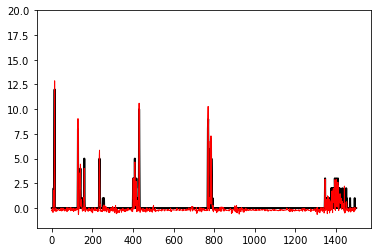

In [18]:
qy_mean_est = np.zeros((1500,neuron_num))
for step, x_batch_train in enumerate(batched_dataset_test):
    qy_mean_est[Time*step:Time*(step+1),:] = vae(x_batch_train)
for i in range(neuron_num):
    plt.figure()
    plt.ylim(-2,20)
    plt.plot(y_data[:,i],"k",linewidth = 2)
    plt.plot(qy_mean_est[:,i],"r",linewidth = 1)

In [20]:
qz_mean_est = np.zeros((all_time,factor_dim))
for step, x_batch_train in enumerate(batched_dataset_test):
    qz_mean_est[Time*step:Time*(step+1),:] = vae.latent(x_batch_train)
wgt = np.linalg.lstsq(qz_mean_est-qz_mean_est.mean(), traj-traj.mean())[0] 
qz_mean_est = np.dot(qz_mean_est,wgt)
qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))

C:\Users\kdais\Anaconda3\envs\py36tg20\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


# Evaluate Quality of reconstruction 

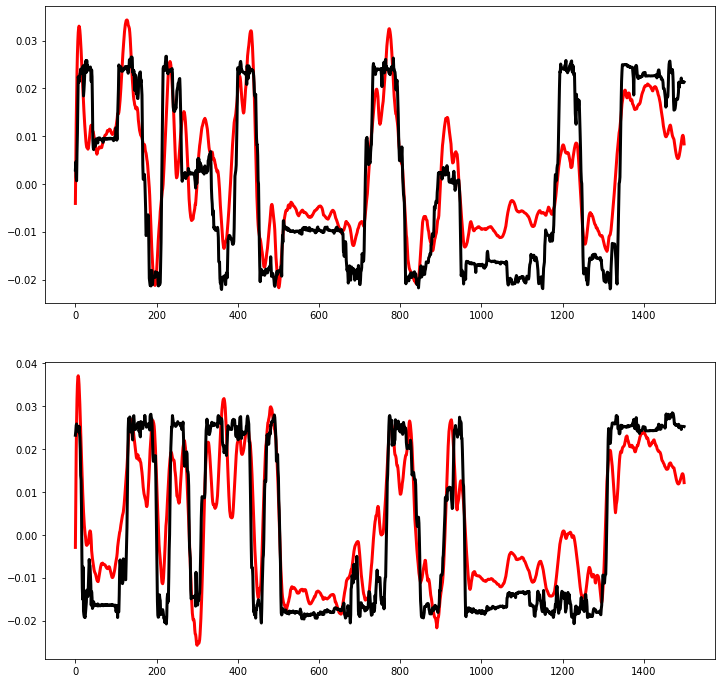

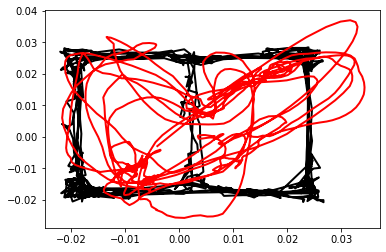

In [21]:

#plt.plot(qz_mean_est[:,0],qz_mean_est[:,1])
#qz_est_c = qz_mean_est - qz_mean_est.mean(axis=0)
#qz_est_norm = qz_est_c/np.linalg.norm(qz_est_c)
#qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
fig = plt.figure(figsize=(12,12))
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], lw=2, color = 'r')